In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import gc
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import tensorflow as tf
import jax
import keras

from sklearn import metrics

from tqdm.notebook import tqdm

print(tf.__version__)
print(jax.__version__)

2024-07-02 13:32:36.017848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 13:32:36.017998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 13:32:36.159547: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
0.4.26


In [2]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

print('Interactive?', is_interactive())

Interactive? False


In [3]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [4]:
DATA = "/kaggle/input/leap-atmospheric-physics-ai-climsim"
DATA_TFREC = "/kaggle/input/leap-train-tfrecords"

In [5]:
sample = pl.read_csv(os.path.join(DATA, "sample_submission.csv"), n_rows=1)
TARGETS = sample.select(pl.exclude('sample_id')).columns
print(len(TARGETS))

368


In [6]:
def _parse_function(example_proto):
    feature_description = {
        'x': tf.io.FixedLenFeature([556], tf.float32),
        'targets': tf.io.FixedLenFeature([368], tf.float32)
    }
    e = tf.io.parse_single_example(example_proto, feature_description)
    return e['x'], e['targets']

In [7]:
train_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100)]
valid_files = [os.path.join(DATA_TFREC, "train_%.3d.tfrec" % i) for i in range(100, 101)]

In [8]:
BATCH_SIZE = 512

train_options = tf.data.Options()
train_options.deterministic = True

ds_train = (
    tf.data.Dataset.from_tensor_slices(train_files)
    .with_options(train_options)
    .shuffle(100)
    .interleave(
        lambda file: tf.data.TFRecordDataset(file).map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE),
        num_parallel_calls=tf.data.AUTOTUNE,
        cycle_length=10,
        block_length=1000,
        deterministic=True
    )
    .shuffle(4 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_valid = (
    tf.data.TFRecordDataset(valid_files)
    .map(_parse_function)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

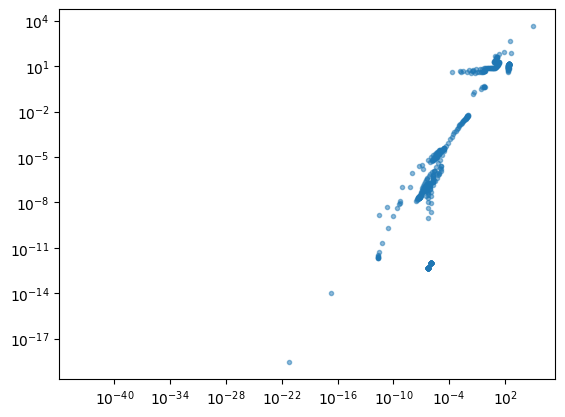

In [9]:
norm_x = keras.layers.Normalization()
norm_x.adapt(ds_train.map(lambda x, y: x).take(20 if is_interactive() else 1000))

plt.scatter(
    norm_x.mean.squeeze(),
    norm_x.variance.squeeze() ** 0.5,
    marker=".",
    alpha=0.5
)
plt.xscale('log')
plt.yscale('log')

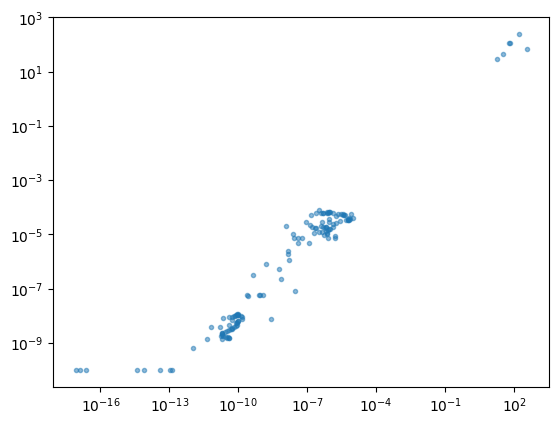

In [10]:
norm_y = keras.layers.Normalization()
norm_y.adapt(ds_train.map(lambda x, y: y).take(20 if is_interactive() else 1000))

mean_y = norm_y.mean
stdd_y = keras.ops.maximum(1e-10, norm_y.variance ** 0.5)

plt.scatter(
    mean_y.squeeze(),
    stdd_y.squeeze(),
    marker=".",
    alpha=0.5
)
plt.xscale('log')
plt.yscale('log')


In [11]:
min_y = np.min(np.stack([np.min(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)
max_y = np.max(np.stack([np.max(yb, 0) for _, yb in ds_train.take(20 if is_interactive() else 1000)], 0), 0, keepdims=True)

### Model definition & Training

In [12]:
@keras.saving.register_keras_serializable(package="MyMetrics", name="ClippedR2Score")
class ClippedR2Score(keras.metrics.Metric):
    def __init__(self, name='r2_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.base_metric = keras.metrics.R2Score(class_aggregation=None)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.base_metric.update_state(y_true, y_pred, sample_weight=None)
        
    def result(self):
        return keras.ops.mean(keras.ops.clip(self.base_metric.result(), 0.0, 1.0))
        
    def reset_states(self):
        self.base_metric.reset_states()

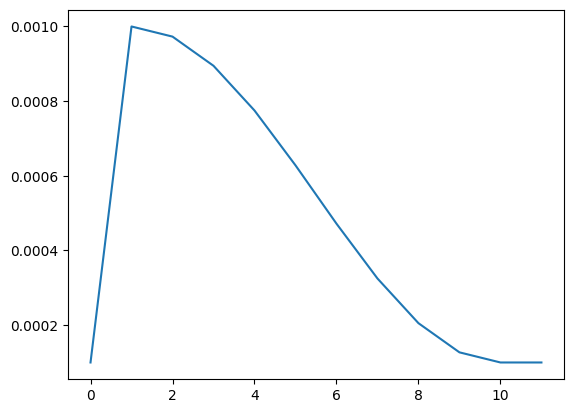

In [13]:
epochs = 12
learning_rate = 1e-3

epochs_warmup = 1
epochs_ending = 2
steps_per_epoch = int(np.ceil(len(train_files) * 100_000 / BATCH_SIZE))

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    1e-4, 
    (epochs - epochs_warmup - epochs_ending) * steps_per_epoch, 
    warmup_target=learning_rate,
    warmup_steps=steps_per_epoch * epochs_warmup,
    alpha=0.1
)

plt.plot([lr_scheduler(it) for it in range(0, epochs * steps_per_epoch, steps_per_epoch)]);

In [14]:
# keras.utils.clear_session()


# def x_to_seq(x):
#     x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
#     x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
#     x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
#     x_flat = keras.ops.repeat(x_flat, 60, axis=1)
#     return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)


# def build_cnn(activation='relu'):    
#     return keras.Sequential([
#         keras.layers.Conv1D(256, 3, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#         keras.layers.Conv1D(128, 3, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#         keras.layers.Conv1D(64, 3, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#     ])


# X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:])
# x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
# x = x_to_seq(x)


# e = e0 = keras.layers.Conv1D(64, 1, padding='same')(x)
# e = build_cnn()(e)
# # add global average to allow some comunication between all levels even in a small CNN
# e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
# e = keras.layers.BatchNormalization()(e)
# e = e + build_cnn()(e)


# p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

# p_seq = p_all[:, :, :6]
# p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
# p_seq = keras.layers.Flatten()(p_seq)
# assert p_seq.shape[-1] == 360

# p_flat = p_all[:, :, 6:6 + 8]
# p_flat = keras.ops.mean(p_flat, axis=1)
# assert p_flat.shape[-1] == 8

# P = keras.ops.concatenate([p_seq, p_flat], axis=1)

# # build & compile
# model = keras.Model(X_input, P)
# model.compile(
#     loss='mse', 
#     optimizer=keras.optimizers.Adam(lr_scheduler),
#     metrics=[ClippedR2Score()]
# )
# model.build(tuple(ds_train.element_spec[0].shape))
# model.summary()

In [15]:
class CustomLoss(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.regularization_factor = regularization_factor
        self.g = 9.81  # 重力加速度

    def call(self, y_true, y_pred):
        # 计算均方误差（MSE）
        mse = keras.ops.mean(keras.ops.square(y_true - y_pred))
        
        # 计算湿静能量守恒惩罚项
        def compute_energy_change(y):
            # 假设 y 的最后一个维度是湿静能量 h
            return keras.ops.sum(keras.ops.diff(y, axis=1), axis=1)  # 对时间维度求导并在压力维度上积分
        
        energy_true = compute_energy_change(y_true)
        energy_pred = compute_energy_change(y_pred)
        
        penalty = keras.ops.mean(keras.ops.square((energy_true - energy_pred) / self.g))
        
        # 总损失函数
        total_loss = mse + self.regularization_factor * penalty
        return total_loss

In [16]:
import keras
from keras.layers import Activation,Conv1D,Add,BatchNormalization,Input,GlobalAveragePooling1D,MultiHeadAttention,Dropout,LayerNormalization,Dense
from keras.models import Model
from keras.utils import clear_session

# 清理会话
clear_session()

# 函数：将输入数据转换为序列格式
def x_to_seq(x):
    x_seq0 = keras.ops.transpose(keras.ops.reshape(x[:, 0:60 * 6], (-1, 6, 60)), (0, 2, 1))
    x_seq1 = keras.ops.transpose(keras.ops.reshape(x[:, 60 * 6 + 16:60 * 9 + 16], (-1, 3, 60)), (0, 2, 1))
    x_flat = keras.ops.reshape(x[:, 60 * 6:60 * 6 + 16], (-1, 1, 16))
    x_flat = keras.ops.repeat(x_flat, 60, axis=1)
    return keras.ops.concatenate([x_seq0, x_seq1, x_flat], axis=-1)

# 残差单元的定义
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = Add()([x, shortcut])
    return x

def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.2):
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    # Feed Forward Network
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Add()([attention_output, ff_output])
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output)
    
    return ff_output

# 构建ResNet模型
def build_resnet(input_shape, output_filters):
    inputs = Input(shape=input_shape)
    x = keras.layers.Conv1D(256, 7, padding='same', activation='relu')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = Conv1D(128, 3, strides=1, padding='same')(x)
    

    
    for _ in range(4):
        x = residual_block(x, 128)
    
    x = Activation('relu')(x)
    x = Conv1D(output_filters, 3, padding='same')(x)
    x = Activation('tanh')(x)

    model = Model(inputs, x)
    return model

# 构建CNN模型
# def build_cnn(activation='relu'):    
#     return keras.Sequential([
#         keras.layers.Conv1D(256, 3, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#         keras.layers.Conv1D(128, 3, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#         keras.layers.Conv1D(64, 3, padding='same', activation=activation),
#         keras.layers.BatchNormalization(),
#     ])

# 输入数据


def build_cnn_transformer_model(num_layers=4, num_heads=8, ff_dim=512, dropout=0.3):
    
    X_input = x = keras.layers.Input(ds_train.element_spec[0].shape[1:])
    x = keras.layers.Normalization(mean=norm_x.mean, variance=norm_x.variance)(x)
    x = x_to_seq(x)


    e = e0 = keras.layers.Conv1D(64, 1, padding='same')(x)
    e = build_resnet(e.shape[1:], 64)(e)
    # add global average to allow some comunication between all levels even in a small CNN
    e = e0 + e + keras.layers.GlobalAveragePooling1D(keepdims=True)(e)
    e = keras.layers.BatchNormalization()(e)
    e = e + build_resnet(e.shape[1:], 64)(e)
    
    # Add multiple Transformer encoder layers
    for _ in range(num_layers):
        e = transformer_encoder(e, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)
    


    p_all = keras.layers.Conv1D(14, 1, padding='same')(e)

    p_seq = p_all[:, :, :6]
    p_seq = keras.ops.transpose(p_seq, (0, 2, 1))
    p_seq = keras.layers.Flatten()(p_seq)
    assert p_seq.shape[-1] == 360

    p_flat = p_all[:, :, 6:6 + 8]
    p_flat = keras.ops.mean(p_flat, axis=1)
    assert p_flat.shape[-1] == 8

    P = keras.ops.concatenate([p_seq, p_flat], axis=1)

    # 构建并编译模型
    model = keras.Model(X_input, P)
    model.compile(
        loss=CustomLoss(), 
        optimizer=keras.optimizers.Adam(lr_scheduler),
        metrics=[ClippedR2Score()]
    )
    return model
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6) 
# Build and compile the model with CNN and Transformer layers
model = build_cnn_transformer_model(num_layers=4, num_heads=8, ff_dim=512, dropout=0.2)


model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 556)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 556)       │          0 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 360)       │          0 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180)       │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 16)        │          0 │ normalization[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6, 60)     │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 60)     │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 16)     │          0 │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose           │ (None, 60, 6)     │          0 │ reshape[0][0]     │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transpose_1         │ (None, 60, 3)     │          0 │ reshape_1[0][0]   │
│ (Transpose)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat (Repeat)     │ (None, 60, 16)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 25)    │          0 │ transpose[0][0],  │
│ (Concatenate)       │                   │            │ transpose_1[0][0… │
│                     │                   │            │ repeat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 64)    │      1,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 60, 64)    │    748,928 │ conv1d[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 60, 64)    │          0 │ conv1d[0][0],     │
│                     │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 64)     │          0 │ functional_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 60, 64)    │          0 │ add_4[0][0],      │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 64)    │        256 │ add_5[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,296,846 (8.76 MB)

 Trainable params: 2,294,926 (8.75 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [17]:
from keras.callbacks import ModelCheckpoint

# 创建 ModelCheckpoint 回调，只保留权重
checkpoint_callback = ModelCheckpoint(
    filepath='model.weights.h5',  # 更改文件名以反映只保存权重
    save_weights_only=True,
    save_best_only=True,  # 只保存验证集上性能最好的权重
    monitor='val_loss',  # 监控验证集损失
    mode='min',  # 当监控指标降低时保存模型
    verbose=1  # 输出保存模型信息
)

# 正常化目标数据集
ds_train_target_normalized = ds_train.map(lambda x, y: (x, (y - mean_y) / stdd_y))
ds_valid_target_normalized = ds_valid.map(lambda x, y: (x, (y - mean_y) / stdd_y))

# 训练模型
history = model.fit(
    ds_train_target_normalized,
    validation_data=ds_valid_target_normalized,
    epochs=epochs,
    verbose=1 if is_interactive() else 2,
    callbacks=[
        checkpoint_callback,  # 使用只保存权重的 ModelCheckpoint 回调
        #early_stopping,  # 你可以取消注释这些行以启用早期停止和学习率调度
        #reduce_lr,
    ]
)

Epoch 1/12

Epoch 1: val_loss improved from inf to 0.28519, saving model to model.weights.h5
19532/19532 - 2723s - 139ms/step - loss: 0.3583 - r2_score: 0.3959 - val_loss: 0.2852 - val_r2_score: 0.4562
Epoch 2/12

Epoch 2: val_loss improved from 0.28519 to 0.26320, saving model to model.weights.h5
19532/19532 - 2689s - 138ms/step - loss: 0.3036 - r2_score: 0.4529 - val_loss: 0.2632 - val_r2_score: 0.4806
Epoch 3/12

Epoch 3: val_loss improved from 0.26320 to 0.25323, saving model to model.weights.h5
19532/19532 - 2674s - 137ms/step - loss: 0.2874 - r2_score: 0.4708 - val_loss: 0.2532 - val_r2_score: 0.4924
Epoch 4/12

Epoch 4: val_loss improved from 0.25323 to 0.24636, saving model to model.weights.h5
19532/19532 - 2678s - 137ms/step - loss: 0.2794 - r2_score: 0.4795 - val_loss: 0.2464 - val_r2_score: 0.4984
Epoch 5/12

Epoch 5: val_loss improved from 0.24636 to 0.23878, saving model to model.weights.h5
19532/19532 - 2676s - 137ms/step - loss: 0.2717 - r2_score: 0.4883 - val_loss: 0.23

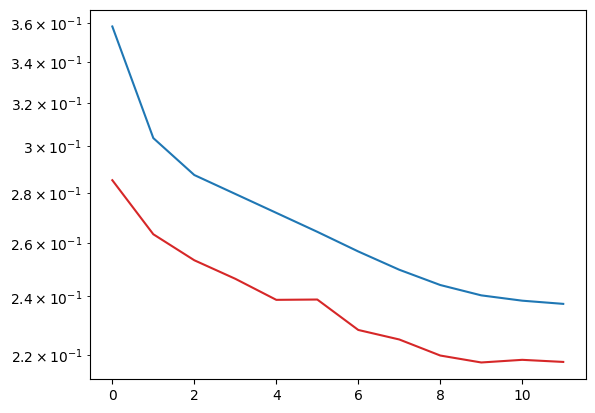

In [18]:
plt.plot(history.history['loss'], color='tab:blue')
plt.plot(history.history['val_loss'], color='tab:red')
plt.yscale('log');

In [19]:
y_valid = np.concatenate([yb for _, yb in ds_valid])
p_valid = model.predict(ds_valid, batch_size=BATCH_SIZE) * stdd_y + mean_y

179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step


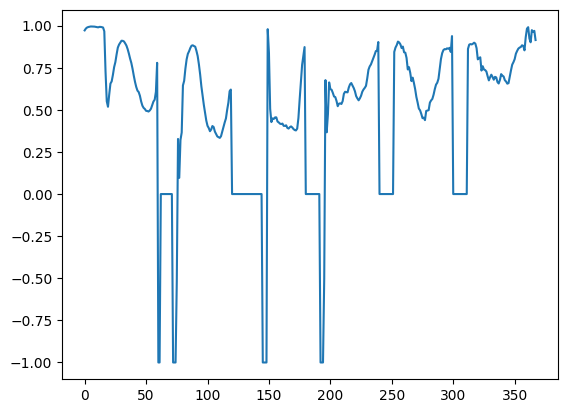

In [20]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(len(TARGETS))])
plt.plot(scores_valid.clip(-1, 1))

In [21]:
mask = scores_valid <= 1e-3
f"Number of under-performing targets: {sum(mask)}"

'Number of under-performing targets: 85'

In [22]:
f"Clipped score: {scores_valid.clip(0, 1).mean()}"

'Clipped score: 0.5235235272064598'

In [23]:
del y_valid, p_valid
gc.collect();

# Submission

In [24]:
sample = pl.read_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv")

In [25]:
df_test = (
    pl.scan_csv("/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv")
    .select(pl.exclude("sample_id"))
    .cast(pl.Float32)
    .collect()
)

In [26]:
p_test = model.predict(df_test.to_numpy(), batch_size=4 * BATCH_SIZE) * stdd_y + mean_y
p_test = np.array(p_test)
p_test[:, mask] = mean_y[:, mask]

2024-07-02 22:32:01.870144: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[2048,128,60]{2,1,0}, u8[0]{0}) custom-call(f32[2048,128,60]{2,1,0}, f32[128,128,3]{2,1,0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-07-02 22:32:02.085253: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.215215132s
Trying algorithm eng3{k11=2} for conv (f32[2048,128,60]{2,1,0}, u8[0]{0}) custom-call(f32[2048,128,60]{2,1,0}, f32[128,128,3]{2,1,0}), window={size=3 pad=1_1}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"co

306/306 ━━━━━━━━━━━━━━━━━━━━ 49s 139ms/step


In [27]:
# correction of ptend_q0002 targets (from 12 to 29)
df_p_test = pd.DataFrame(p_test, columns=TARGETS)

for idx in range(12, 30):
    df_p_test[f"ptend_q0002_{idx}"] = -df_test[f"state_q0002_{idx}"].to_numpy() / 1200
    
p_test = df_p_test.values

In [28]:
submission = sample.to_pandas()
submission[TARGETS] = submission[TARGETS] * p_test
pl.from_pandas(submission[["sample_id"] + TARGETS]).write_csv("submission.csv")